In [13]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch

In [3]:
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.repository.datasets import dataset_recipes, get_dataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import MultivariateEvaluator

from pts.model.deepar import DeepAREstimator
from pts.dataset.repository.datasets import dataset_recipes
from pts.modules import StudentTOutput

2023-03-16 16:48:32.206246: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-16 16:48:32.867397: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-16 16:48:32.867465: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-16 16:48:32.867473: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed proper

## Prepeare data set

In [4]:
dataset = get_dataset("solar_nips", regenerate=False)

In [5]:
dataset.metadata

MetaData(freq='H', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat_0', cardinality='137')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=24)

In [6]:
train_grouper = MultivariateGrouper(max_target_dim=int(dataset.metadata.feat_static_cat[0].cardinality))

test_grouper = MultivariateGrouper(num_test_dates=int(len(dataset.test)/len(dataset.train)), 
                                   max_target_dim=int(dataset.metadata.feat_static_cat[0].cardinality))

In [7]:
dataset_train = train_grouper(dataset.train)
dataset_test = test_grouper(dataset.test)

## Evaluator

In [8]:
evaluator = MultivariateEvaluator(quantiles=(np.arange(20)/20.0)[1:],
                                  target_agg_funcs={'sum': np.sum})

## `DeepVAR`

In [9]:
estimator = DeepAREstimator(
    distr_output=StudentTOutput(dim=int(dataset.metadata.feat_static_cat[0].cardinality)),
    input_size=int(dataset.metadata.feat_static_cat[0].cardinality),
    hidden_size=128,
    num_layers=3,
    dropout_rate=0.1,
    lags_seq=[1, 24*7],
  
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length,
    freq=dataset.metadata.freq,
    scaling="std",
    trainer_kwargs=dict(max_epochs=50, accelerator='gpu', devices='1'),
)

In [10]:
predictor = estimator.train(dataset_train, cache_data=True)

Authorization required, but no authorization protocol specified
Authorization required, but no authorization protocol specified
Authorization required, but no authorization protocol specified
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:72: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA GeForce RTX 3090 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Ty

Training: 0it [00:00, ?it/s]

Epoch 0, global step 50: 'train_loss' reached 638.32812 (best 638.32812), saving model to '/home/kashif/pytorch-ts/examples/lightning_logs/version_43/checkpoints/epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 525.38483 (best 525.38483), saving model to '/home/kashif/pytorch-ts/examples/lightning_logs/version_43/checkpoints/epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 507.54712 (best 507.54712), saving model to '/home/kashif/pytorch-ts/examples/lightning_logs/version_43/checkpoints/epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 499.83633 (best 499.83633), saving model to '/home/kashif/pytorch-ts/examples/lightning_logs/version_43/checkpoints/epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 489.12500 (best 489.12500), saving model to '/home/kashif/pytorch-ts/examples/lightning_logs/version_43/checkpoints/epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: '

In [12]:
forecast_it, ts_it = make_evaluation_predictions(dataset=dataset_test,
                                             predictor=predictor,
                                             num_samples=100)
forecasts = list(forecast_it)
targets = list(ts_it)
agg_metric, _ = evaluator(targets, forecasts, num_series=len(dataset_test))

Running evaluation: 7it [00:00, 99.51it/s]
Running evaluation: 7it [00:00, 97.43it/s]
Running evaluation: 7it [00:00, 98.71it/s]
Running evaluation: 7it [00:00, 99.06it/s]
Running evaluation: 7it [00:00, 98.82it/s]
Running evaluation: 7it [00:00, 98.71it/s]
Running evaluation: 7it [00:00, 98.41it/s]
Running evaluation: 7it [00:00, 98.77it/s]
Running evaluation: 7it [00:00, 98.83it/s]
Running evaluation: 7it [00:00, 98.76it/s]
Running evaluation: 7it [00:00, 98.46it/s]
Running evaluation: 7it [00:00, 99.19it/s]
Running evaluation: 7it [00:00, 94.42it/s]
Running evaluation: 7it [00:00, 101.50it/s]
Running evaluation: 7it [00:00, 98.36it/s]
Running evaluation: 7it [00:00, 98.27it/s]
Running evaluation: 7it [00:00, 98.93it/s]
Running evaluation: 7it [00:00, 98.96it/s]
Running evaluation: 7it [00:00, 97.49it/s]
Running evaluation: 7it [00:00, 98.48it/s]
Running evaluation: 7it [00:00, 99.16it/s]
Running evaluation: 7it [00:00, 99.03it/s]
Running evaluation: 7it [00:00, 98.11it/s]
Running ev

### Metrics

In [14]:
print("CRPS: {}".format(agg_metric['mean_wQuantileLoss']))
print("ND: {}".format(agg_metric['ND']))
print("NRMSE: {}".format(agg_metric['NRMSE']))
print("MSE: {}".format(agg_metric['MSE']))

CRPS: 0.48256447191548785
ND: 0.5784218569873304
NRMSE: 1.1535902311471327
MSE: 1262.353320653794


In [15]:
print("CRPS-Sum: {}".format(agg_metric['m_sum_mean_wQuantileLoss']))
print("ND-Sum: {}".format(agg_metric['m_sum_ND']))
print("NRMSE-Sum: {}".format(agg_metric['m_sum_NRMSE']))
print("MSE-Sum: {}".format(agg_metric['m_sum_MSE']))

CRPS-Sum: 0.48362846540385784
ND-Sum: 0.5225882150465829
NRMSE-Sum: 0.9255859440197299
MSE-Sum: 15252900.761904761


In [16]:
def plot(target, forecast, prediction_length, prediction_intervals=(50.0, 90.0), color='g', fname=None):
    label_prefix = ""
    rows = 4
    cols = 4
    fig, axs = plt.subplots(rows, cols, figsize=(24, 24))
    axx = axs.ravel()
    seq_len, target_dim = target.shape
    
    ps = [50.0] + [
            50.0 + f * c / 2.0 for c in prediction_intervals for f in [-1.0, +1.0]
        ]
        
    percentiles_sorted = sorted(set(ps))
    
    def alpha_for_percentile(p):
        return (p / 100.0) ** 0.3
        
    for dim in range(0, min(rows * cols, target_dim)):
        ax = axx[dim]

        target[-2 * prediction_length :][dim].plot(ax=ax)
        
        ps_data = [forecast.quantile(p / 100.0)[:,dim] for p in percentiles_sorted]
        i_p50 = len(percentiles_sorted) // 2
        
        p50_data = ps_data[i_p50]
        p50_series = pd.Series(data=p50_data, index=forecast.index)
        p50_series.plot(color=color, ls="-", label=f"{label_prefix}median", ax=ax)
        
        for i in range(len(percentiles_sorted) // 2):
            ptile = percentiles_sorted[i]
            alpha = alpha_for_percentile(ptile)
            ax.fill_between(
                forecast.index,
                ps_data[i],
                ps_data[-i - 1],
                facecolor=color,
                alpha=alpha,
                interpolate=True,
            )
            # Hack to create labels for the error intervals.
            # Doesn't actually plot anything, because we only pass a single data point
            pd.Series(data=p50_data[:1], index=forecast.index[:1]).plot(
                color=color,
                alpha=alpha,
                linewidth=10,
                label=f"{label_prefix}{100 - ptile * 2}%",
                ax=ax,
            )

    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]    
    axx[0].legend(legend, loc="upper left")
    
    if fname is not None:
        plt.savefig(fname, bbox_inches='tight', pad_inches=0.05)

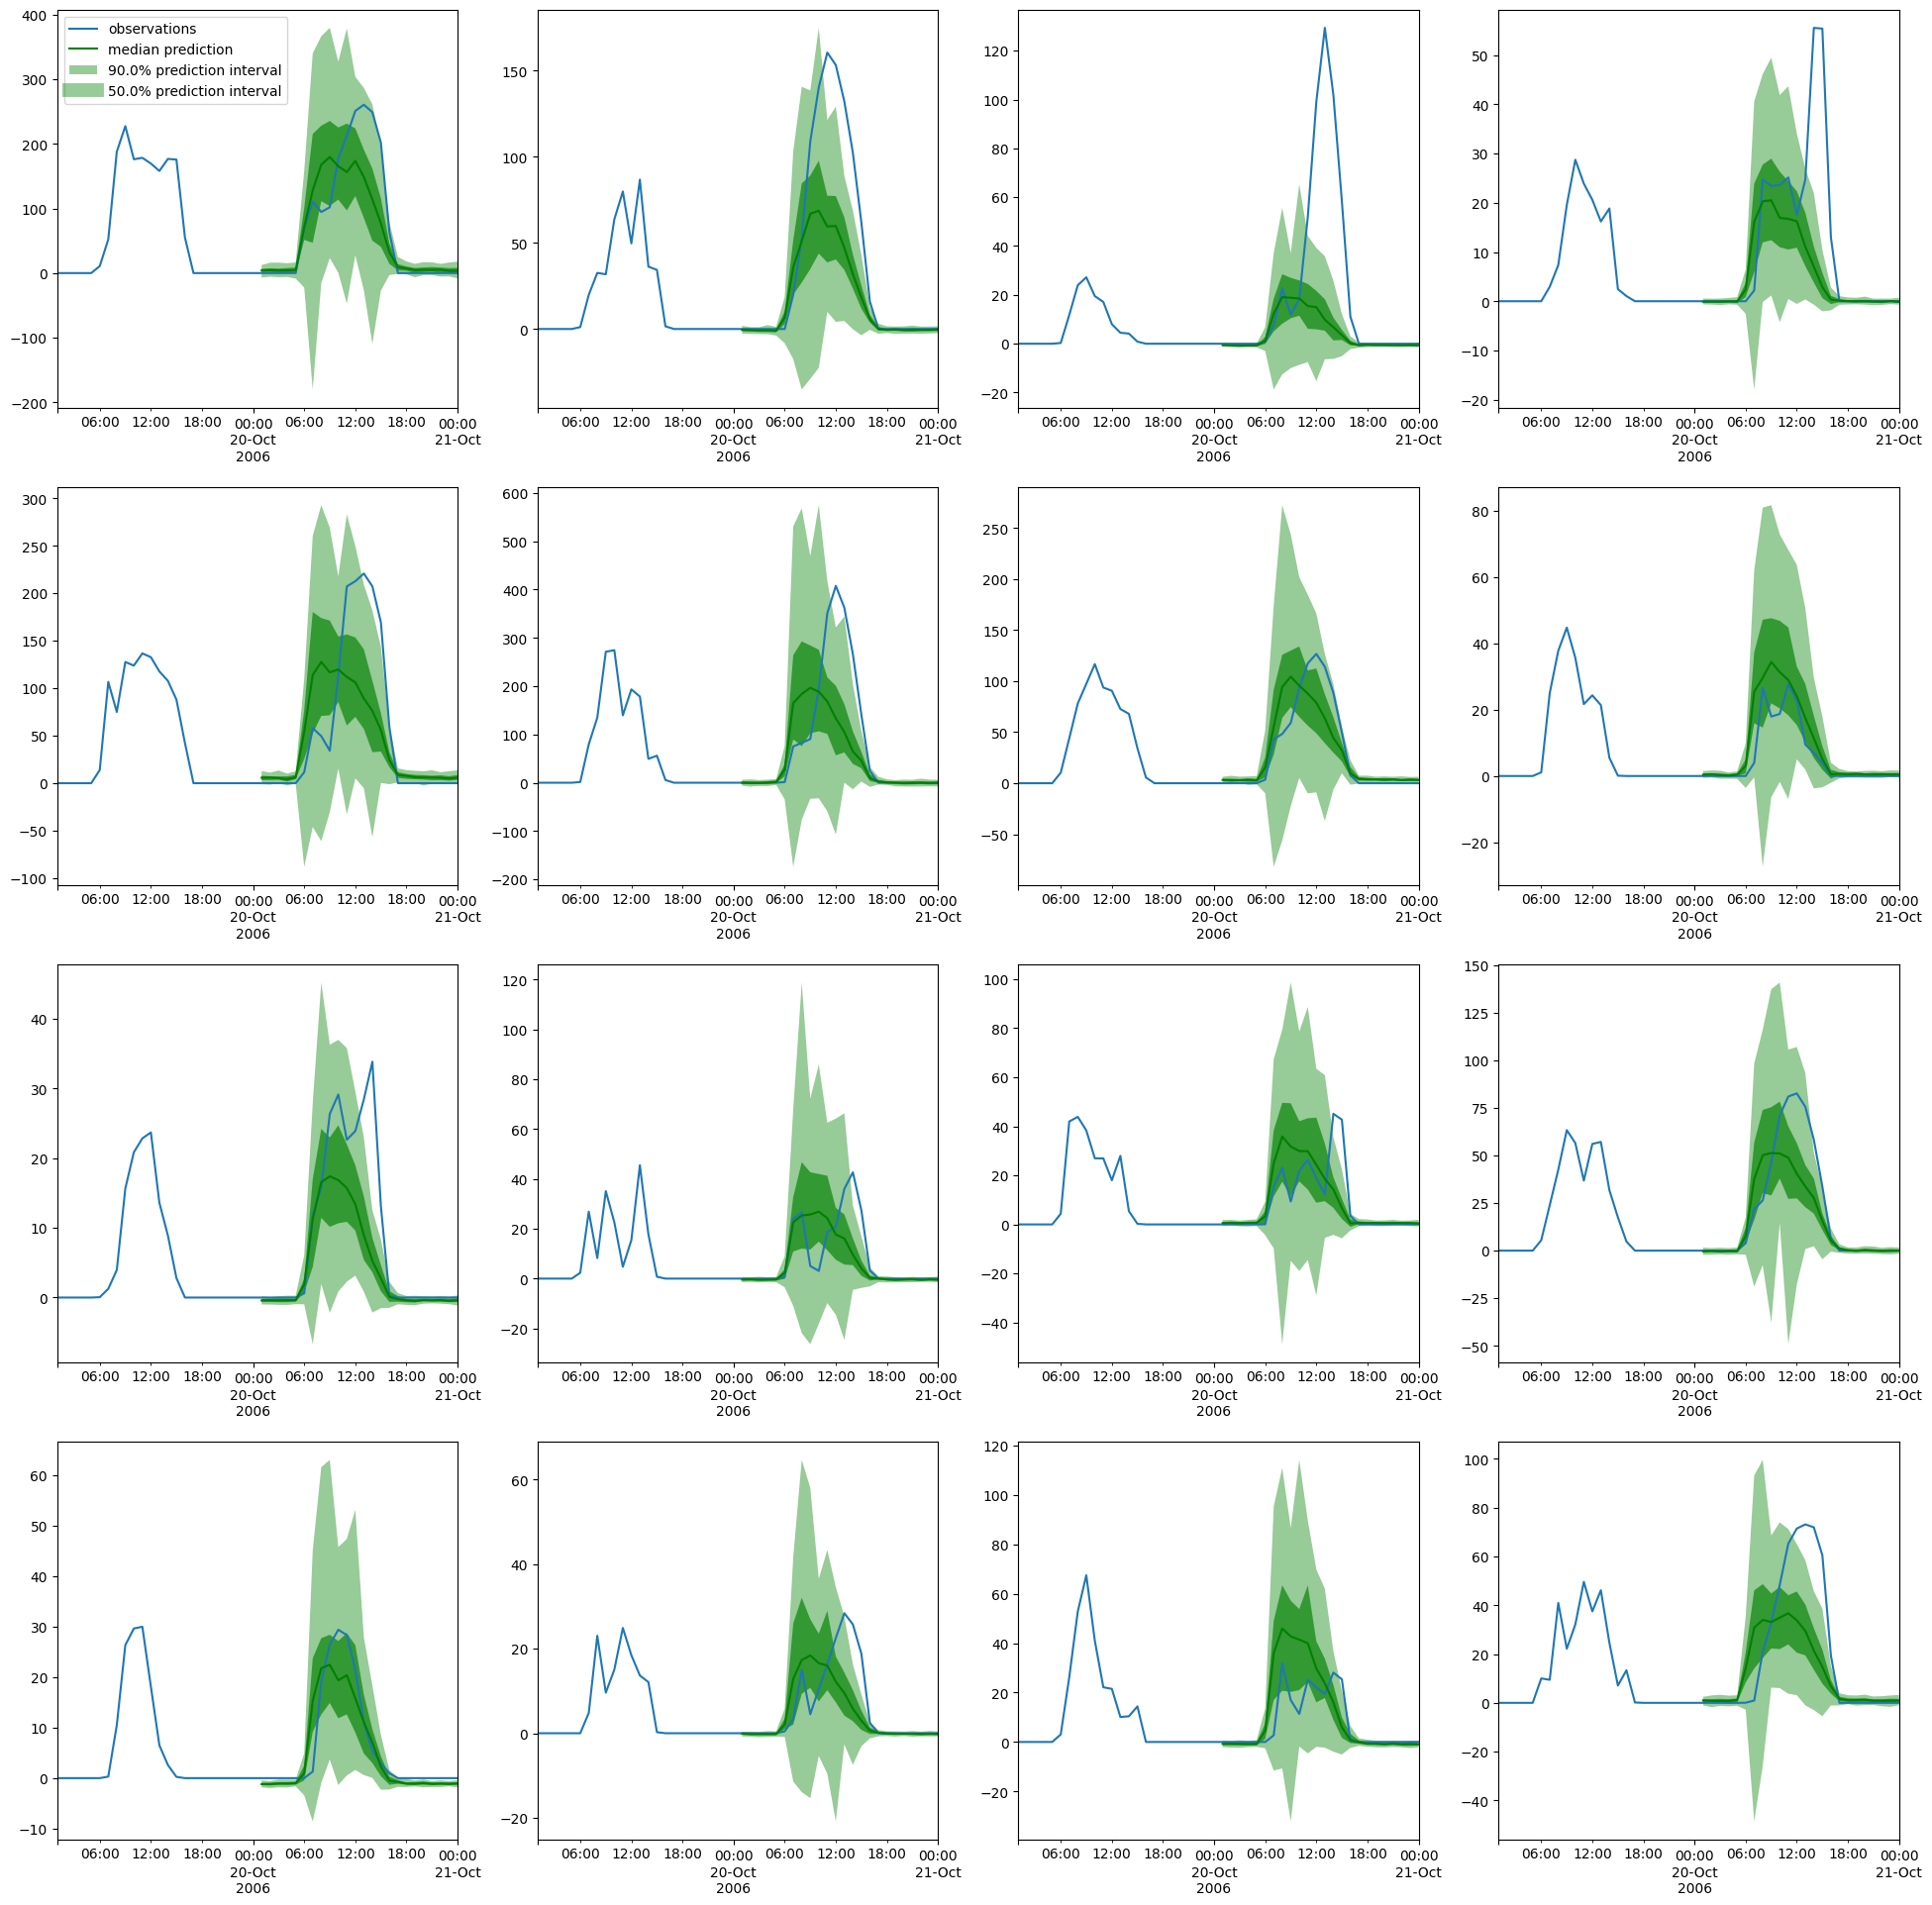

In [17]:
plot(
    target=targets[0],
    forecast=forecasts[0],
    prediction_length=dataset.metadata.prediction_length,
)
plt.show()